In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense,Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_path='banign vs malignant/train'
valid_path='banign vs malignant/valid'
test_path='banign vs malignant/test'

In [4]:
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=['benign','malignant'],batch_size=6)
valid_batches=ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=['benign','malignant'],batch_size=3)
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['benign','malignant'],batch_size=6)

Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [5]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [6]:
imgs,labels=next(train_batches)

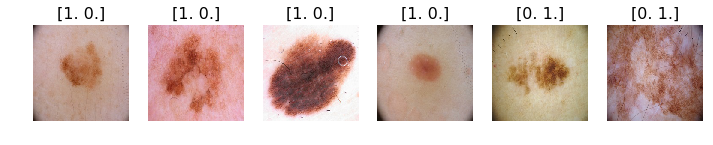

In [7]:
plots(imgs,titles=labels)

## Sequential Model

In [8]:
model=Sequential([
    Conv2D(32,(3,3),activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2,activation='softmax'),
])

In [9]:
model.compile(Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
model.fit_generator(train_batches,steps_per_epoch=4,validation_data=valid_batches,validation_steps=3,epochs=1,verbose=1)

Epoch 1/1
4/4 [==============================] - 3s 664ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 7.1636 - val_acc: 0.5556


## Predict 

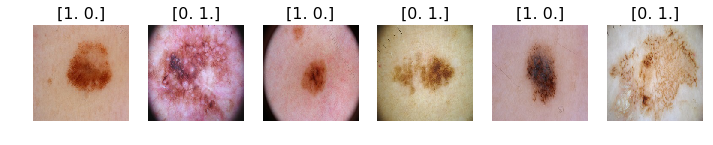

In [14]:
test_imgs,test_labels=next(test_batches)
plots(test_imgs,titles=test_labels)

In [15]:
test_labels=test_labels[:,0]
test_labels

array([1., 0., 1., 0., 1., 0.], dtype=float32)

In [16]:
from math import ceil
prediction=model.predict_generator(test_batches,steps=1,verbose=2)
prediction

array([[6.2370185e-36, 1.0000000e+00],
       [9.6937496e-36, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [6.6703934e-29, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [17]:
prediction[:,0].astype(int)

array([0, 0, 0, 0, 0, 0])

In [18]:
cm=confusion_matrix(test_labels,np.round(prediction[:,0]))

In [19]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without Normalization")
    
    print(cm)
    
    thresh=cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center",color="white" if cm[i,j]>thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Confusion Matrix, without Normalization
[[3 0]
 [3 0]]


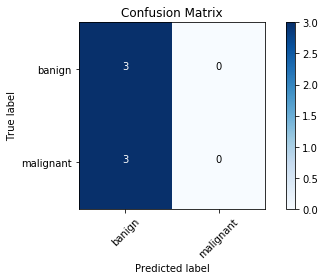

In [20]:
cm_plot_labels=["banign","malignant"]
plot_confusion_matrix(cm,cm_plot_labels,title="Confusion Matrix")

## Build Fine-tuned VGG16 Model

In [21]:
vgg16_model=keras.applications.vgg16.VGG16(weights=, include_top=False)

In [22]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [24]:
from keras.layers import Input, Dense

input = Input(shape=(3,224,224),name = 'image_input')

In [26]:
output_vgg16_conv = vgg16_model(input)

ValueError: number of input channels does not match corresponding dimension of filter, 224 != 3

In [ ]:
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

In [ ]:
my_model = Model(input=input, output=x)

In [ ]:
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
my_model.fit_generator(train_batches,steps_per_epoch=5,validation_data=valid_batches,validation_steps=2,epochs=10,verbose=1)

## Train the Fine tuned VGG16 model


In [63]:
from keras import optimizers

In [64]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [65]:
model.compile(sgd,loss='categorical_crossentropy',metrics=["accuracy"])

In [72]:
model.fit_generator(train_batches,steps_per_epoch=2,validation_data=valid_batches,validation_steps=2,epochs=10,verbose=1)

Epoch 1/10
2/2 [==============================] - 8s 4s/step - loss: 0.2466 - acc: 0.6944 - val_loss: 0.8036 - val_acc: 0.5000
Epoch 2/10
2/2 [==============================] - 9s 4s/step - loss: 0.1020 - acc: 1.0000 - val_loss: 0.2976 - val_acc: 0.7500
Epoch 3/10
2/2 [==============================] - 8s 4s/step - loss: 0.2804 - acc: 0.8056 - val_loss: 1.1257 - val_acc: 0.5000
Epoch 4/10
2/2 [==============================] - 9s 4s/step - loss: 0.0800 - acc: 0.9167 - val_loss: 0.0756 - val_acc: 1.0000
Epoch 5/10
2/2 [==============================] - 8s 4s/step - loss: 0.1017 - acc: 0.9028 - val_loss: 1.1103 - val_acc: 0.5000
Epoch 6/10
2/2 [==============================] - 9s 4s/step - loss: 0.1856 - acc: 0.8333 - val_loss: 0.2061 - val_acc: 1.0000
Epoch 7/10
2/2 [==============================] - 8s 4s/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.9904 - val_acc: 0.5000
Epoch 8/10
2/2 [==============================] - 9s 4s/step - loss: 0.0897 - acc: 0.9167 - val_loss: 0.7263 - 

In [ ]:
#score, acc =model.evaluate(test_batches,batch_size=2)
'''score = model.evaluate(test_imgs,test_labels)
print('Test score:', score[0])
print('Test accuracy:',score[1])'''

## Predicting

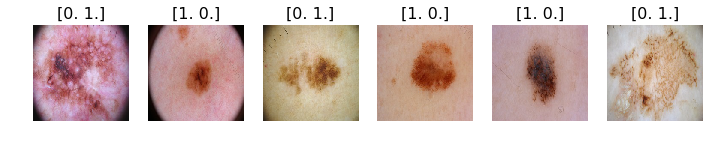

In [41]:
test_imgs,test_labels=next(test_batches)
plots(test_imgs,titles=test_labels)

In [42]:
test_labels=test_labels[:,0]
test_labels

array([0., 1., 0., 1., 1., 0.], dtype=float32)

In [73]:
prediction=model.predict_generator(test_batches,steps=1,verbose=1)

1/1 [==============================] - 3s 3s/step


In [74]:
prediction[:,0]

array([9.9822825e-01, 3.0182593e-02, 2.2847478e-03, 9.9468863e-01,
       2.9263925e-04, 9.9773991e-01], dtype=float32)

In [75]:
cm=confusion_matrix(test_labels,np.round(prediction[:,0]))

Confusion Matrix, without Normalization
[[1 2]
 [2 1]]


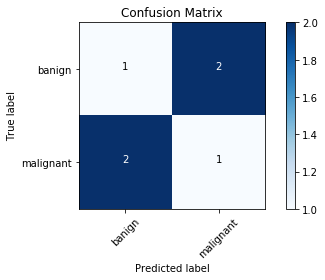

In [76]:
cm_plot_labels=["banign","malignant"]
plot_confusion_matrix(cm,cm_plot_labels,title="Confusion Matrix")